In [1]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/nlp_project/data_timeseries.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [2]:
data.shape

(3019, 7)

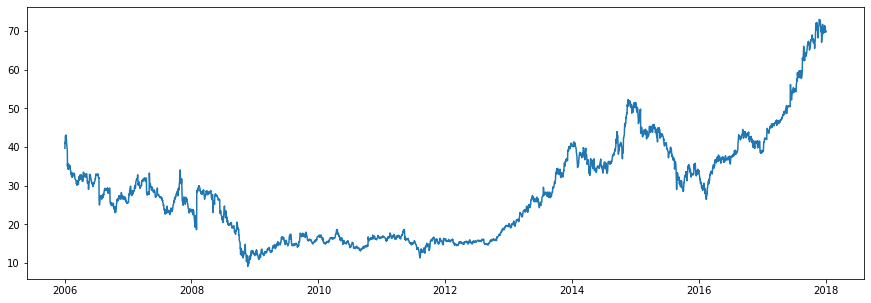

In [3]:
import matplotlib.pyplot as plt

date = pd.to_datetime(data.Date)
open = data.Open.values.astype(float)

plt.figure(figsize=(15, 5))
plt.plot(date, open)
plt.show()

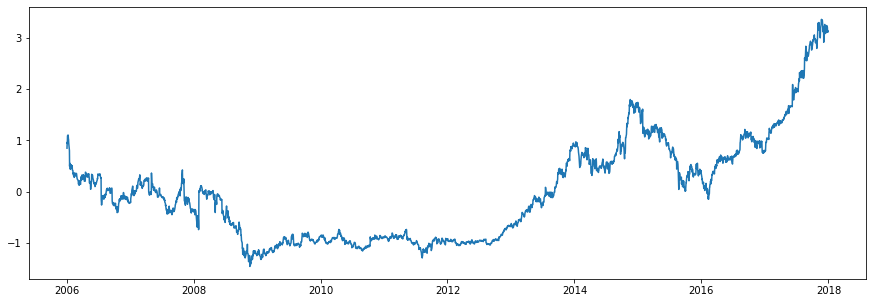

In [4]:
from sklearn.preprocessing import scale

# Normalisasi data open
open = scale(data.Open.values.astype(float))

plt.figure(figsize=(15, 5))
plt.plot(date, open)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# Membagi data 80% training, 20% validasi
x_train, x_test, Y_train, Y_test = train_test_split(open, date, test_size=0.2, random_state = 32, shuffle=False)

In [6]:
import tensorflow as tf
import numpy as np

# mae 10% skala data
max_mae = (np.max(open) - np.min(open))*0.1

# Class callback
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('mae') < max_mae):
          print(f"\nTraining dihentikan, mae < {max_mae}")   
          self.model.stop_training = True

# Memanggil class callback
callbacks = myCallback()

# Membuat fungsi windowed_dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

# Training dan Validasi ke fungsi windowed_dataset
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)

# Membuat model
model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(128, return_sequences=True),
                    tf.keras.layers.LSTM(64),
                    tf.keras.layers.Dense(64, activation="relu"),
                    tf.keras.layers.Dense(32, activation="relu"),
                    tf.keras.layers.Dense(1)
                    ])

In [7]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(
                                    learning_rate=1.0000e-04,
                                    momentum=0.9
                                    )
# Compile model
model.compile(
              loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]
              )
# Melatih model
history = model.fit(
                    train_set,
                    validation_data = val_set,
                    epochs=100,
                    batch_size=30,
                    callbacks=[callbacks]
                    )

Epoch 1/100
24/24 [==============================] - 12s 294ms/step - loss: 0.3220 - mae: 0.7011 - val_loss: 0.8577 - val_mae: 1.2960
Epoch 2/100
24/24 [==============================] - 6s 254ms/step - loss: 0.3085 - mae: 0.6846 - val_loss: 0.8534 - val_mae: 1.2915
Epoch 3/100
24/24 [==============================] - 6s 255ms/step - loss: 0.2939 - mae: 0.6674 - val_loss: 0.8486 - val_mae: 1.2866
Epoch 4/100
24/24 [==============================] - 6s 251ms/step - loss: 0.2829 - mae: 0.6541 - val_loss: 0.8431 - val_mae: 1.2811
Epoch 5/100
24/24 [==============================] - 6s 255ms/step - loss: 0.2740 - mae: 0.6429 - val_loss: 0.8379 - val_mae: 1.2758
Epoch 6/100
24/24 [==============================] - 6s 251ms/step - loss: 0.2657 - mae: 0.6322 - val_loss: 0.8331 - val_mae: 1.2710
Epoch 7/100
24/24 [==============================] - 6s 260ms/step - loss: 0.2575 - mae: 0.6217 - val_loss: 0.8275 - val_mae: 1.2651
Epoch 8/100
24/24 [==============================] - 6s 255ms/step -

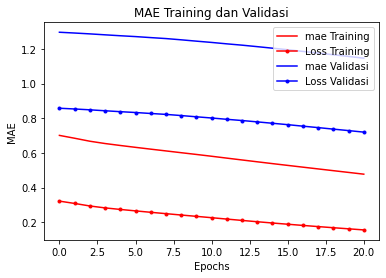

<Figure size 432x288 with 0 Axes>

In [8]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'r', label='mae Training')
plt.plot(epochs, loss, 'r', marker='.', label='Loss Training')
plt.plot(epochs, val_mae, 'b', label='mae Validasi')
plt.plot(epochs, val_loss, 'b', marker='.', label='Loss Validasi')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('MAE Training dan Validasi')
plt.legend()
plt.figure()

plt.show()

Nama : Tomi Nurhidayat

E-mail : tomi.nurhidayat933@gmail.com